In [1]:
# !pip install torch
# !pip install torchvision
# !pip install PIL
# !pip install utils

In [2]:
import argparse
import numpy as np
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
print(torch.__version__, torchvision.__version__)
# from utils import label_to_onehot, cross_entropy_for_onehot


2.1.0+cpu 0.16.0+cpu


In [3]:
parser = argparse.ArgumentParser(description='Deep Leakage from Gradients.')
parser.add_argument('--index', type=int, default="25",help='the index for leaking images on CIFAR.')
parser.add_argument('--image', type=str,default="",help='the path to customized image.')
device='cpu'
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)


Running on cpu


In [4]:
# args = parser.parse_args()
device = "cpu"

In [5]:
import random

In [6]:
dstc = datasets.CIFAR100("~/.torch", download=True)
dstm = datasets.MNIST("~/.torch", download=True)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()
img_index = 25
gt_data = tp(dstc[img_index][0]).to(device)

Files already downloaded and verified


In [7]:
num_imagesm = len(dstm)
num_imagesc = len(dstc)
num_images_to_select = 10
# Generate 10 random image indices
random_indicesm = random.sample(range(num_imagesm), num_images_to_select)
selected_indicesm = random_indicesm
random_indicesc = random.sample(range(num_imagesc), num_images_to_select)
selected_indicesc = random_indicesc
# Print the selected indices
print("Selected Image Indices:", selected_indicesm)

Selected Image Indices: [24342, 51557, 45145, 26519, 6559, 32590, 58122, 49544, 20495, 42109]


In [8]:
gt_data.shape

torch.Size([3, 32, 32])

In [9]:
# if len(args.image) > 1:
#     gt_data = Image.open(args.image)
#     gt_data = tp(gt_data).to(device)

In [10]:
gt_data = gt_data.view(1, *gt_data.size())
gt_data.shape

torch.Size([1, 3, 32, 32])

In [11]:
dstm[img_index][1]

2

In [12]:
gt_label = torch.Tensor([dstc[img_index][1]]).long().to(device)
gt_label

tensor([84])

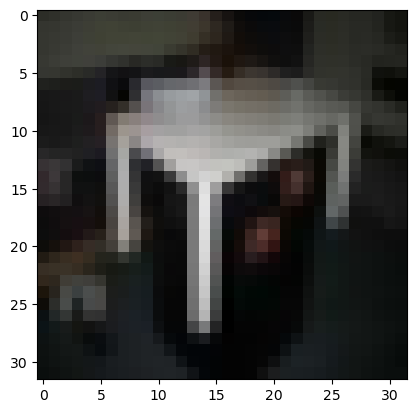

In [13]:
 plt.imshow(tt(gt_data.squeeze(0).cpu()))


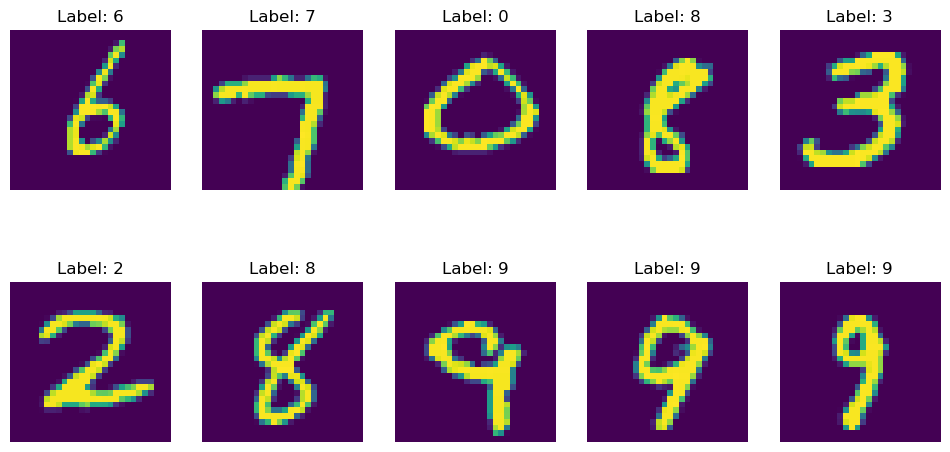

In [14]:
def load_and_display_images(dataset, random_indices):
    tp = transforms.ToTensor()
    tt = transforms.ToPILImage()
    device = "cpu" 
    selected_images = []
    labels = []
    for img_index in random_indices:
        gt_data = tp(dataset[img_index][0]).to(device)
        gt_data = gt_data.view(1, *gt_data.size())
        labels.append(dataset[img_index][1])
        selected_images.append(tt(gt_data.squeeze(0).cpu()))

    return selected_images, labels

selected_imagesm, selected_labelsm = load_and_display_images(dstm, selected_indicesm)

selected_imagesc, selected_labelsc = load_and_display_images(dstc, selected_indicesc)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(len(selected_imagesm)):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(selected_imagesm[i])
    axes[row, col].set_title(f"Label: {selected_labelsm[i]}")
    axes[row, col].axis('off')

plt.show()


In [15]:
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

# Lenet

In [16]:
class LeNetMNIST(nn.Module):
    def __init__(self):
        super(LeNetMNIST, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),  # Reduce padding and stride
            act(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Add max-pooling
            nn.Conv2d(6, 16, kernel_size=5, stride=1),  # Adjust kernel size and stride
            act(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Add max-pooling
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),  # Adjust the number of input features
            act(),
            nn.Linear(120, 84),
            act(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


class LeNetCIFAR(nn.Module):
    def __init__(self):
        super(LeNetCIFAR, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),  # Input channels: 3 (color image)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 100)  # Output classes: 10 (CIFAR-10)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



In [17]:
import torch
import torch.nn.functional as F
def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [18]:
gt_label = torch.Tensor([dstc[img_index][1]]).long().to(device)
gt_label = gt_label.view(1, )
print(gt_label)
gt_onehot_label = label_to_onehot(gt_label)
print(gt_onehot_label)

tensor([84])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [19]:
modelm = LeNetMNIST().to(device)
modelc=LeNetCIFAR().to(device)
torch.manual_seed(1234)

In [20]:
modelm.apply(weights_init)
modelc.apply(weights_init)
criterion = cross_entropy_for_onehot

In [21]:
modelc

LeNetCIFAR(
  (body): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=100, bias=True)
  )
)

In [22]:
# !pip install torchsummary
from torchsummary import summary
summary(modelm, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
           Sigmoid-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
           Sigmoid-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
           Sigmoid-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
          Sigmoid-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [23]:
summary(modelc, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                  [-1, 100]           8,500
Total params: 69,656
Trainable params: 69,656
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

# Original Gradient

In [24]:
# compute original gradient 
pred = modelc(gt_data)
print(pred.shape)
y = criterion(pred, gt_onehot_label)
dy_dx = torch.autograd.grad(y, modelc.parameters())

original_dy_dx = list((_.detach().clone() for _ in dy_dx))

torch.Size([1, 100])


In [25]:
print(original_dy_dx)

[tensor([[[[ 7.7976e+00,  3.1506e+00,  4.8381e+00,  1.1314e+01,  2.0285e+01],
          [ 8.0383e+00,  2.7801e+00,  1.7182e+00,  3.8371e+00,  1.3684e+01],
          [ 8.0093e+00,  2.8731e+00,  1.6467e+00,  1.7676e+00,  8.8074e+00],
          [ 8.3696e+00,  3.1762e+00,  1.4649e+00,  1.6726e+00,  8.2779e+00],
          [ 8.9447e+00,  3.7942e+00,  1.7317e+00,  1.5740e+00,  8.1256e+00]],

         [[ 7.9445e+00,  3.2030e+00,  4.7979e+00,  1.1240e+01,  2.0178e+01],
          [ 8.0795e+00,  2.7886e+00,  1.7294e+00,  3.8462e+00,  1.3694e+01],
          [ 8.1136e+00,  2.8907e+00,  1.6650e+00,  1.7950e+00,  8.8257e+00],
          [ 8.4831e+00,  3.2114e+00,  1.4392e+00,  1.6680e+00,  8.3053e+00],
          [ 8.9215e+00,  3.6780e+00,  1.6566e+00,  1.6015e+00,  8.1530e+00]],

         [[ 7.9680e+00,  3.3544e+00,  4.9768e+00,  1.1198e+01,  2.0066e+01],
          [ 8.0932e+00,  2.8214e+00,  1.7843e+00,  3.8554e+00,  1.3703e+01],
          [ 8.1063e+00,  2.9123e+00,  1.6734e+00,  1.8133e+00,  8.8532e

In [26]:
def load_and_compute_gradients(dataset, selected_indices, selected_labels, model,c):
    tp = transforms.ToTensor()
    device = "cpu"
    selected_original_dy_dx = []  # List to store original gradients for all images

    for img_index, gt_label in zip(selected_indices, selected_labels):
        gt_data = tp(dataset[img_index][0]).to(device)
        gt_data = gt_data.view(1, *gt_data.size())
        gt_label = torch.Tensor([gt_label]).long().to(device)
        gt_label = gt_label.view(1, )

        # Compute original gradient
        pred = model(gt_data)
        y = criterion(pred, label_to_onehot(gt_label,c))
        dy_dx = torch.autograd.grad(y, model.parameters())

        original_dy_dx = [_.detach().clone() for _ in dy_dx]
        selected_original_dy_dx.append(original_dy_dx)

    return selected_original_dy_dx

# Assuming you have `dst` dataset, `selected_indices`, and `selected_labels`
selected_original_dy_dxm = load_and_compute_gradients(dstm, selected_indicesm, selected_labelsm, modelm,10)
selected_original_dy_dxc = load_and_compute_gradients(dstc, selected_indicesc, selected_labelsc, modelc,100)


In [27]:
print(len(selected_original_dy_dxm))

10


# DLG

## Deep Leakage from Gradients

The given code describes a differential privacy algorithm for generating private training data.

**Inputs:**
- Model F(x; W): The neural network model.
- weights W: The model's weights.
- Gradients of training data ∇W: The gradients computed on the training data.
- n: The number of iterations.
- α: A hyperparameter controlling privacy.
- ℓ2R2(x): Regularization term.
- η: A learning rate.
- x'₁ and y'₁: Initial noise vectors generated from a normal distribution.

**Output:**
- Private training data (x'ₙ₊₁, y'ₙ₊₁).

### Step-by-Step Execution

1. **Initialization:**
   - Initialize x'₁ and y'₁ with noise sampled from a normal distribution:
     - x'₁ ~ N(0, 1)
     - y'₁ ~ N(0, 1)

2. **Iteration Loop:**
   For i from 1 to n (for n iterations):
   a. Compute ∇Wₜ:
      - ∇Wₜ = ∂L(F(x'ₜ, Wₜ), y'ₜ), where L is the loss function.

   b. Calculate the Loss D:
      - D = ∥∇Wₜ - ∇W∥₂ + αℓ₂R²(x), where ∇W is the true gradient and αℓ₂R²(x) is a regularization term.

   c. Update x'ᵢ₊₁:
      - x'ᵢ₊₁ = x'ᵢ - η∇x'ᵢD

   d. Update y'ᵢ₊₁:
      - y'ᵢ₊₁ = y'ᵢ - η∇y'ᵢD

3. **Output:**
   Return the final noisy input x'ₙ₊₁ and noisy label y'ₙ₊₁ as the private training data.


# step1:Random noised data and label

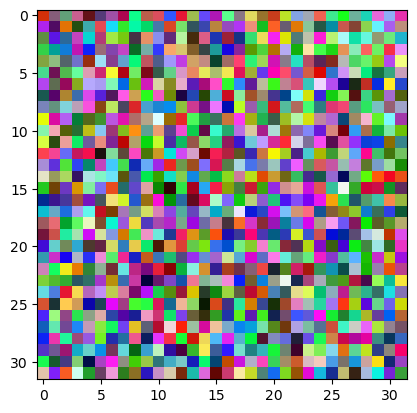

In [28]:
# generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))


In [29]:
dummy_label

tensor([[-0.0612, -0.4783, -0.1772, -0.8334,  0.5758, -1.4251, -0.4557,  0.2190,
         -0.6265, -0.1131,  1.5146,  1.3173,  0.5576, -2.9182,  1.4535,  1.2861,
         -0.0145,  0.0162, -0.4197,  1.6069,  2.2130, -0.3936, -0.4475, -0.2370,
         -1.6923, -0.9236,  1.7629, -0.7594, -1.5478, -0.7090,  1.0996, -0.1850,
         -0.0945,  0.2688,  0.7883,  1.4690,  0.5925,  0.3216, -0.3069, -0.8868,
          1.4566, -0.6199,  0.3445, -0.3121,  1.4720, -0.6359,  0.3051,  0.4158,
          0.6337,  0.1738, -0.7716,  1.0794, -0.2636,  1.0755,  1.3371, -0.6390,
          1.0611,  1.1508, -0.6550, -0.1538,  1.1934,  0.3221, -0.3352, -0.2892,
          1.0755, -1.5414,  1.0895,  1.0224,  1.2577,  1.3079, -1.2567,  0.6127,
         -0.8046, -0.6277,  0.3060, -1.8005, -1.8755, -2.0434, -0.8551,  1.1572,
         -0.1325, -1.1153, -1.3515, -0.7646, -0.2955,  0.1840, -0.8886,  1.6832,
         -0.8710, -0.7568, -0.0706, -0.5284, -0.4238, -0.7018, -0.4879, -0.8592,
          1.1754, -1.9167, -

# step2:Iterative Optimization

In [30]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

In [31]:
history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        dummy_pred = modelc(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
        dummy_dy_dx = torch.autograd.grad(dummy_loss, modelc.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))

0 477610.9688
10 477598.4062
20 477598.4062
30 477598.4062
40 477598.4062
50 477598.4062
60 477598.4062
70 477598.4062
80 477598.4062
90 477598.4062
100 477598.4062
110 477598.4062
120 477598.4062
130 477598.4062
140 477598.4062
150 477598.4062
160 477598.4062
170 477598.4062
180 477598.4062
190 477598.4062
200 477598.4062
210 477598.4062
220 477598.4062
230 477598.4062
240 477598.4062
250 477598.4062
260 477598.4062
270 477598.4062
280 477598.4062
290 477598.4062


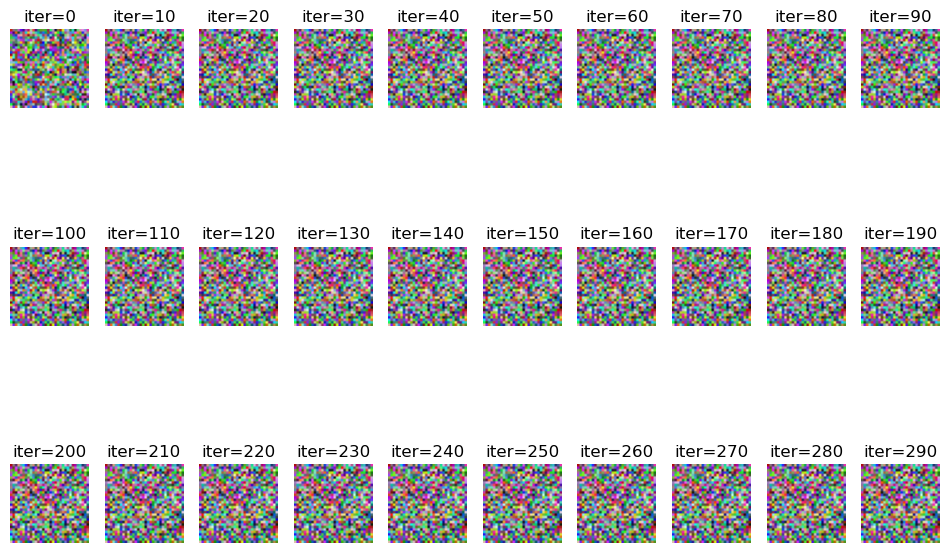

In [33]:
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i])
    plt.title("iter=%d" % (i * 10))
    plt.axis('off')

plt.show()

In [35]:
def DLG(model, original_dy_dx, device, criterion, history, num_iterations=600,data='c'):
    tp = transforms.ToTensor()
    tt = transforms.ToPILImage()
    recovered_images = []
    for original_grad in original_dy_dx:
        if data=='m':
            dummy_data = torch.randn(1,1,28,28).to(device).requires_grad_(True)
            dummy_label = torch.randn(1, 10).to(device).requires_grad_(True)
        else:
            dummy_data = torch.randn(1,3,32,32).to(device).requires_grad_(True)
            dummy_label = torch.randn(1, 100).to(device).requires_grad_(True) 

        optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

        for iters in range(num_iterations):
            def closure():
                optimizer.zero_grad()
                dummy_pred = model(dummy_data)
                dummy_onehot_label = F.softmax(dummy_label, dim=-1)
                dummy_loss = criterion(dummy_pred, dummy_onehot_label)
                dummy_dy_dx = grad(dummy_loss, model.parameters(), create_graph=True)
                grad_diff=0
                for dummy_g, original_g in zip(dummy_dy_dx, original_grad):
                    grad_diff+=((dummy_g - original_g) ** 2).sum()
                grad_diff.backward()
                return grad_diff
            optimizer.step(closure)
            if iters == num_iterations - 1:
                current_loss = closure()
                print(current_loss)
                recovered_image = tt(dummy_data[0].cpu())
                recovered_images.append(recovered_image)

    return recovered_images

recovered_imagesm = DLG(modelm, selected_original_dy_dxm, device, criterion, history,data='m')


tensor(0.5141, grad_fn=<AddBackward0>)
tensor(0.0142, grad_fn=<AddBackward0>)
tensor(0.8100, grad_fn=<AddBackward0>)
tensor(0.0104, grad_fn=<AddBackward0>)
tensor(0.0330, grad_fn=<AddBackward0>)
tensor(0.0115, grad_fn=<AddBackward0>)
tensor(0.8960, grad_fn=<AddBackward0>)
tensor(0.0140, grad_fn=<AddBackward0>)
tensor(0.0081, grad_fn=<AddBackward0>)
tensor(0.0101, grad_fn=<AddBackward0>)


In [36]:
recovered_imagesc = DLG(modelc, selected_original_dy_dxc, device, criterion, history)

tensor(621854.1875, grad_fn=<AddBackward0>)
tensor(1015631.3750, grad_fn=<AddBackward0>)
tensor(7.5589e+13, grad_fn=<AddBackward0>)
tensor(1136524.3750, grad_fn=<AddBackward0>)
tensor(816935.7500, grad_fn=<AddBackward0>)
tensor(235462.4688, grad_fn=<AddBackward0>)
tensor(691569.5000, grad_fn=<AddBackward0>)
tensor(604250.5000, grad_fn=<AddBackward0>)
tensor(604270.7500, grad_fn=<AddBackward0>)
tensor(22708.2012, grad_fn=<AddBackward0>)


In [37]:
def calculate_mse(original_image, recovered_image):
    diff = original_image - recovered_image
    mse = torch.mean(diff ** 2)
    return mse.item()

def PSNR(original_image, recovered_image):
    mse = calculate_mse(original_image, recovered_image)
    if mse == 0:
        return float('inf')
    max_pixel_value = 255  # Assuming 8-bit images
    psnr = 20 * (np.log10(max_pixel_value) - np.log10(np.sqrt(mse)))
    return psnr

def SSIM(original_image, recovered_image):
    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2
    mu_x = torch.mean(original_image)
    mu_y = torch.mean(recovered_image)
    sigma_x = torch.std(original_image)
    sigma_y = torch.std(recovered_image)
    sigma_xy = torch.mean((original_image - mu_x) * (recovered_image - mu_y))
    # SSIM calculation
    numerator = (2 * mu_x * mu_y + c1) * (2 * sigma_xy + c2)
    denominator = (mu_x ** 2 + mu_y ** 2 + c1) * (sigma_x ** 2 + sigma_y ** 2 + c2)
    ssim_value = numerator/denominator
    return ssim_value.item()


In [38]:
gt_data.shape

torch.Size([1, 3, 32, 32])

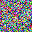

In [39]:
history[9]

In [40]:
rec_data = tp(history[9]).to(device)

In [41]:
rec_data.shape

torch.Size([3, 32, 32])

In [42]:
rec_data = rec_data.view(1, *rec_data.size())

In [43]:
gt_data_np = gt_data.cpu().detach().numpy()
rec_data_np = rec_data.cpu().detach().numpy()

In [44]:
rec_data.shape

torch.Size([1, 3, 32, 32])

In [45]:
mse = calculate_mse(gt_data,rec_data)
psnr_value = PSNR(gt_data, rec_data)
ssim_value = SSIM(gt_data, rec_data)

In [46]:
print(f"MSE: {mse:.2f}")
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.2f}")
# print(f"LPIPS: {lpips_value:.2f}")


MSE: 0.21
PSNR: 54.83 dB
SSIM: 0.98


*MSE (Mean Squared Error):* MSE measures the average squared difference between the pixels of two images. A lower MSE indicates a closer match between the original and the recovered image. an MSE of 0.33 suggests that, on average, the pixels in the recovered image differ from the original image by a relatively small amount.

*PSNR (Peak Signal-to-Noise Ratio):* PSNR measures the quality of an image by comparing it to a perfect image (with no noise or distortion). It's expressed in decibels (dB). A higher PSNR indicates a higher quality image. a 52.91 dB is relatively high, suggesting that the quality of the recovered image is quite close to the original.

*SSIM (Structural Similarity Index):* SSIM is a perception-based model that measures the structural similarity between two images. It considers luminance, contrast, and structure. SSIM values range from -1 to 1, where 1 indicates a perfect match. An SSIM of 0.97 is quite high and suggests a strong structural similarity between the original and the recovered image.

In [47]:
def calculate_metrics(original, recovered):
    mse = calculate_mse(original, recovered)
    psnr = PSNR(original, recovered)
    ssim = SSIM(original, recovered)
    return mse, psnr, ssim

In [48]:
# selected_images[0],recovered_images[0]

In [49]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),transforms.ToTensor(),])
img = transform(selected_imagesm[0]).unsqueeze(0)
# img = img.unsqueeze(0)
img.shape

torch.Size([1, 1, 28, 28])

In [50]:
def evaluate_and_plot_metrics(selected_images, recovered_images, transform):
    mse_list = []
    psnr_list = []
    ssim_list = []

    for original_image, recovered_image in zip(selected_images, recovered_images):
        org_data = transform(original_image).unsqueeze(0)
        rec_data = transform(recovered_image).unsqueeze(0)
        mse, psnr, ssim = calculate_metrics(org_data, rec_data)
        mse_list.append(mse)
        psnr_list.append(psnr)
        ssim_list.append(ssim)

    fig, axes = plt.subplots(3, 10, figsize=(20, 8))

    for i, image in enumerate(selected_images):
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f"Image {i + 1}")
        axes[0, i].axis('off')

    for i, image in enumerate(recovered_images):
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title(f"Recovered {i + 1}")
        axes[1, i].axis('off')

    for i in range(10):
        axes[2, i].text(0.5, 0.5, f"MSE: {mse_list[i]:.2f}\nPSNR: {psnr_list[i]:.2f}\nSSIM: {ssim_list[i]:.2f}", ha='center', va='center', fontsize=10)
        axes[2, i].axis('off')

    plt.show()

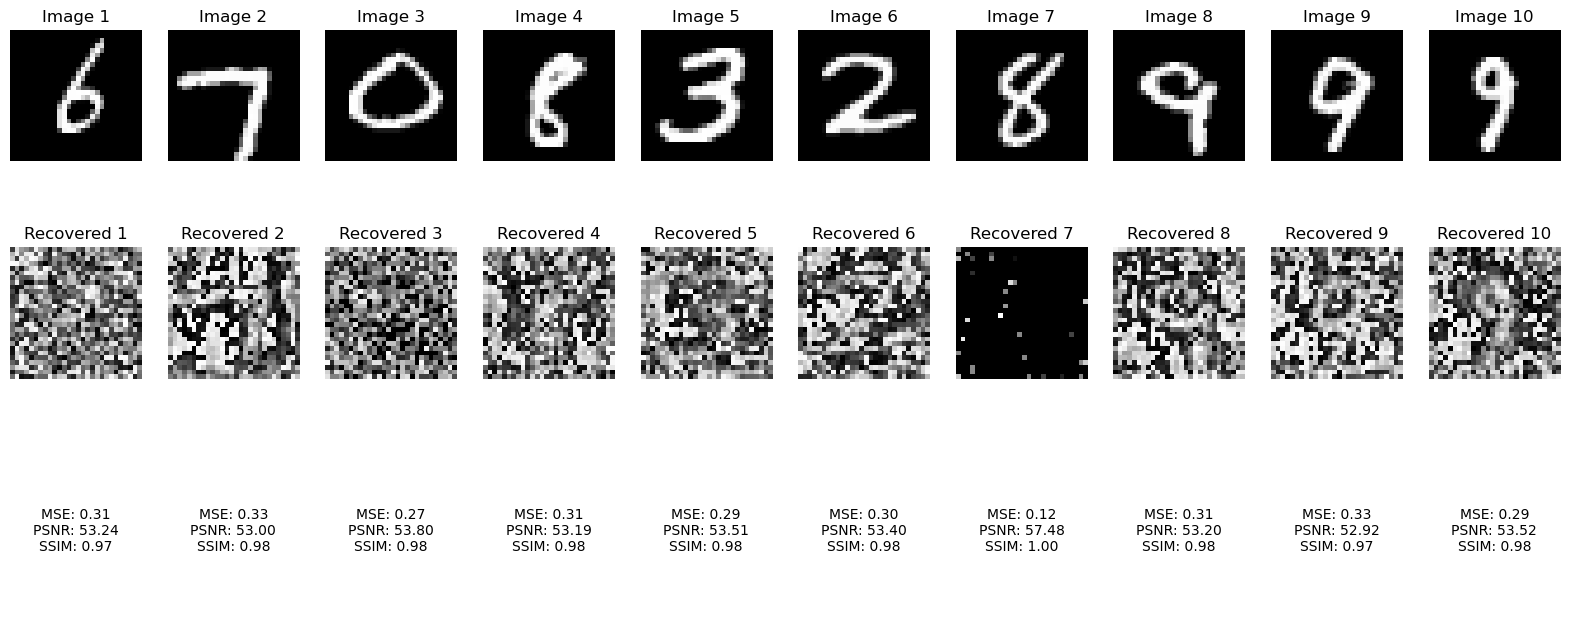

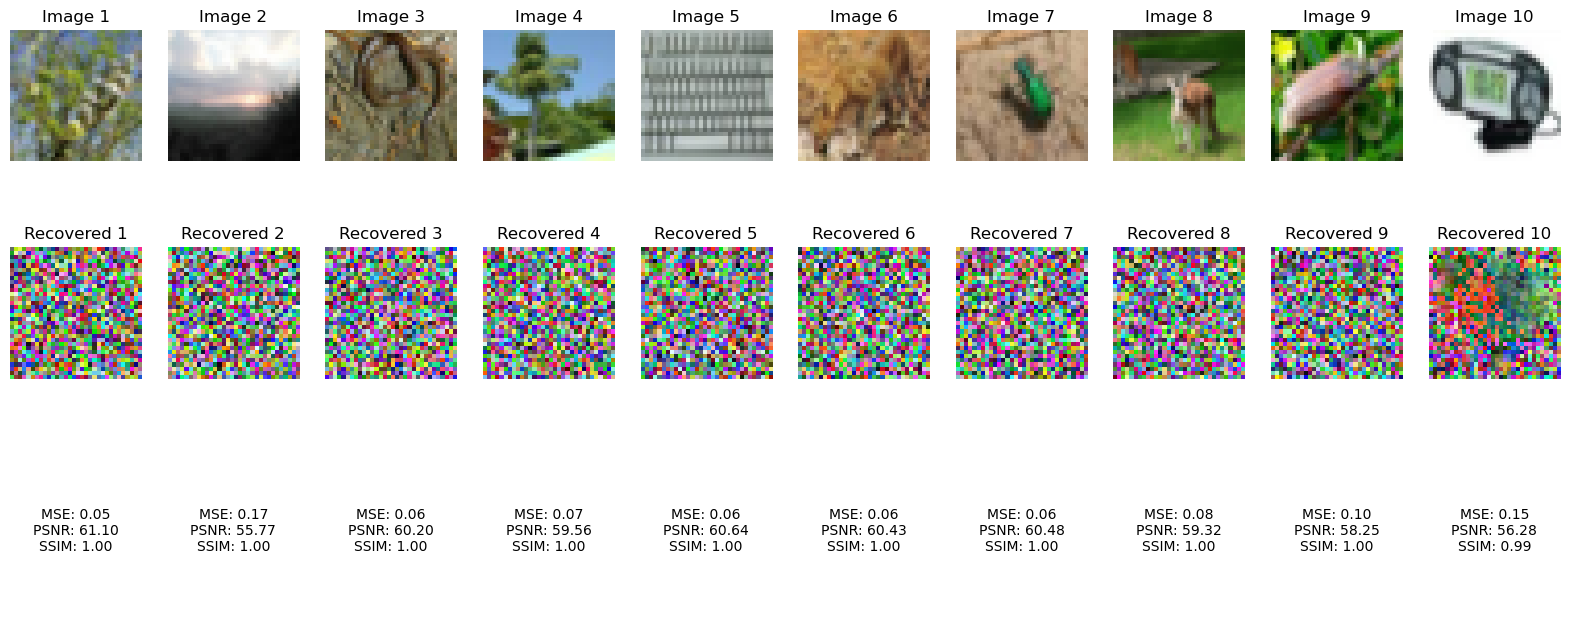

In [51]:
evaluate_and_plot_metrics(selected_imagesm, recovered_imagesm, transform)
evaluate_and_plot_metrics(selected_imagesc, recovered_imagesc, transform)
